In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Part 1: Data Exploration and Evaluation

### Loading 

In [2]:
raw_data = pd.read_csv("loan.csv",  usecols = ['loan_amnt',
                                                'funded_amnt', 
                                                'term', 
                                                'int_rate', 
                                                'grade', 
                                                'annual_inc', 
                                                'issue_d', 
                                                'dti', 
                                                'revol_bal', 
                                                'total_pymnt', 
                                                'loan_status'])
data = raw_data.copy()

### Cleaning and Aggregation

1. As dti is a ratio of annual_inc, and as anual_inc can sometimes be zero (apparently without violating the credit policy), removing the income ratio from the dti column serves to reduce any potentially spurious correlation, while removing the division-by-zero issue with the dti column.<sup><a href="#1" name="back1">1</a></sup>
2. I will replace the "loan_amnt" column with a "reduced_by" column. This will reduce the possibility that multicollinearity will be an issue in the regression,<sup><a href="#2" name="back2">2</a></sup> while retaining all initial information.

In [3]:
data["dti"] = data["dti"]*data["annual_inc"]
data["reduced_by"] = data["loan_amnt"] - data["funded_amnt"]
data = data.drop("loan_amnt",axis=1)
data["issue_d"] = pd.to_datetime(raw_data["issue_d"]) #Standard Conversion to datetime type

### Assumptions made to handle null variables and outliers

1. Loans that "Do not meet the credit policy" will not help us understand the characteristics of loans we make with the credit policy. Additionally, some have issues, like missing income values.<sup><a href="#3" name="back3">3</a></sup> Thus, I will exclude these loans from my analysis.
2. The "loan_status" column will be taken at face value, though there are several hundred loans which are marked as "fully paid", yet have a total_pymnt of less than the principle.<sup><a href="#4" name="back4">4</a></sup> I err on the side of the "loan_status" indicator, which might factor in circumstances not represented in the data. However I'm curious about this inconsistency. In a business setting, I would certainly follow up with questions about this.
3. Extremely large annual incomes (and revolving balances) are not errors of some kind, but represent a small subset of (wealthy) customers.<sup><a href="#5" name="back5">5</a></sup>

In [4]:
data = data.loc[~(data["loan_status"] == 'Does not meet the credit policy. Status:Fully Paid')]
data = data.loc[~(data["loan_status"] == 'Does not meet the credit policy. Status:Charged Off')]

### Description of the feature distributions

1. **funded_amnt:** Characterized by several extremely popular loan amounts ($\$10,000$, $\$20,000$, $\$35,000$), with a maximum value set at $\$35,000$. Low value loans are more common than high value, with an average of about $\$15,000$.<sup><a href="#6" name="back6">6</a></sup> **loan_amnt** is much the same, except occasionally higher than funded amount, in circumstances where a loan was given below the requested amount.<sup><a href="#7" name="back7">7</a></sup>
2. **term:** There are a little over twice as many more 36 month loans than 60 month loans in the entire dataset.<sup><a href="#8" name="back8">8</a></sup>
3. **int_rate:** Like the funded amount, this value is also characterized by some popular amounts. Varies between 5% and 30%, with most values falling bellow 20%, and an average of 13.2%.<sup><a href="#9" name="back9">9</a></sup>
4. **grade:** Seems to be approximately normal, with F and G grades being fairly rare, and B and C grades being the most common. It's almost too normal, which suggests to me that it may have been manufactured post-hoc.<sup><a href="#10" name="back10">10</a></sup>
5. **annual_inc:** Follows a lognormal distribution, which is to be expected generally from income data. <sup><a href="#11" name="back11">11</a></sup>
6. **issue_d:** The data shows a clear exponential uptick in loan origination year on year, for the entire window of analysis. The month of origination is fairly uniform overall, though in recent year variance month to month has increased quite a bit. <sup><a href="#12" name="back12">12</a></sup>
7. **loan_status:** Most of the loans are current. Current loans and fully paid loans make up the vast majority of cases. There are a few loans with uncommon statuses. <sup><a href="#13" name="back13">13</a></sup>
8. **dti:** Follows a lognormal distribution, with outliers at the high end. Once corrected by multiplying by income, a few remaining outliers at zero make sense, probably indicating borrowers with no other debts.<sup><a href="#14" name="back14">14</a></sup>
9. **revol_bal:** Follows a lognormal distribution, with a few outliers at zero. These represent folks without revolving balances, which makes sense.<sup><a href="#15" name="back15">15</a></sup>
10. **total_pymnt:** An exponentially diminishing distribution that represents that a large number of loans are still in repayment. All payment of course starts at zero and progresses to the loan amount.<sup><a href="#16" name="back16">16</a></sup>
11. **reduced_by:** 99% of loans are not reduced. Of those that are, most are reduced between 5 and 10 thousand dollars.<sup><a href="#17" name="back17">17</a></sup>

### Two data visualizations and two summary statistics that support these findings

**Distribution of Funded Amount**

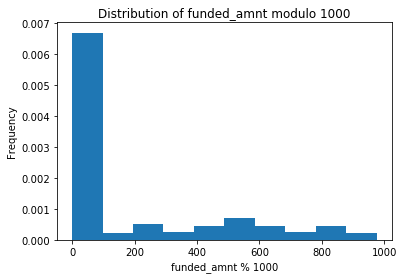

In [5]:
ax = (raw_data['funded_amnt'] % 1000).plot(kind="hist", density=True);
ax.set_title("Distribution of funded_amnt modulo 1000");
ax.set_xlabel("funded_amnt % 1000");

This chart illustrates that funded amount is almost always a multiple of $\$1000$, indicating that the variable is not truly continuous in practice.

**Date of Origination**

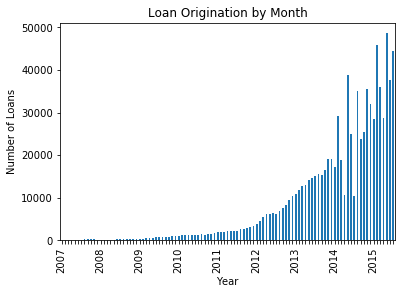

In [6]:
dates = pd.to_datetime(raw_data["issue_d"]) #Standard Conversion to datetime type
ax = dates.value_counts().sort_index().plot(kind="bar");
ax.set_xticklabels([str(int(i/12)) if i % 12 == 0 else "" for i in range(2007*12,2016*12+1)]);
ax.set_title("Loan Origination by Month");
ax.set_ylabel("Number of Loans");
ax.set_xlabel("Year");

This chart illustrates that loan origination has increased exponentially since 2007, while variance has also increased considerably.

**Distribution of Total Payment**

In [7]:
round(100*np.median(raw_data["total_pymnt"])/np.max(raw_data["total_pymnt"]),2)

8.47

The median is only 8% of the max value for the total_pymnt column, which illustrates the frontloaded-ness of the distribution of total payment.

**Distribution of Loan Status**

In [8]:
round(100*sum(np.logical_or(raw_data["loan_status"] == "Current" , 
                            raw_data["loan_status"] == "Fully Paid"))/len(raw_data),2)

91.22

Loans which are either current or fully paid make up 91% of the total number, the vast majority of cases.

### Assumption of a 36 month investment period for each loan

There are two loan terms in this data set. 36 month and 60 month loans. I will investigate only the loans with a term of 36 months.

In [9]:
data = data.loc[data["term"] == " 36 months"]
data = data.drop("term", axis=1)

### Exclusion of loans with less than 36 months of data available

We have data up to but not including January 1, 2016. Thus, all loans originated before January 1, 2013 should have 36  months of data available. Notably, this reduces the size of our data set by a factor of 10.<sup><a href="#18" name="back18">18</a></sup>

In [10]:
data = data.loc[data["issue_d"] <  pd.to_datetime("01/01/2013")]
data = data.reset_index().drop("index",axis=1) #reindexing

### What percentage of loans have been fully paid?

Per my discussion above, I will be taking the loan status column at face value. 

In [11]:
round(100*sum(data["loan_status"] == "Fully Paid")/len(data),2)

87.31

In this data 87.31% of the loans have been fully paid

### When bucketed by year of origination and grade, which cohort has the highest rate of defaults?

In [12]:
data["defaulted"] = (data["loan_status"] != "Fully Paid")

In [13]:
temp = data[["grade","issue_d","defaulted"]].copy()
temp["year"] = temp["issue_d"].dt.year
temp = temp.drop("issue_d", axis=1)
(temp.groupby(["grade","year"])["defaulted"].sum()/temp.groupby(["grade","year"])["defaulted"].count()).idxmax()

('G', 2008)

The cohort of "G" rated loans from 2008 has the highest rate of defaults, (50%), though there are only 4 loans in that bucket.<sup><a href="#20" name="back20">20</a></sup>

### When bucketed by year of origination and grade, what annualized rate of return have these loans generated on average?

I'll use the suggested approximation:

$$\textrm{Annualized rate of return} =\left(\frac{\textrm{total_pymnt}}{\textrm{funded_amnt}}\right)^\frac{1}{3} - 1$$

In [14]:
annualized_ror = lambda total_pymnt,funded_amnt : ((total_pymnt/funded_amnt)**(1/3)) -1

In [15]:
sumarry = {}
for g in set(data["grade"]):
    sumarry[g] = {}
    for yr in set(data["issue_d"].dt.year):
        tp = data[np.logical_and(data["grade"] == g, data["issue_d"].dt.year == yr)]["total_pymnt"]
        fa = data[np.logical_and(data["grade"] == g, data["issue_d"].dt.year == yr)]["funded_amnt"]
        if len(tp) > 0:
            sumarry[g][yr] =  round(100*np.mean(annualized_ror(tp,fa)),2).astype(str)
        else:
            sumarry[g][yr] = "N/A"
        

In [16]:
df = pd.DataFrame(sumarry)
df = df.reindex(sorted(df.columns), axis=1)
df.style.set_caption("Average Annualized Rate of Return by Year of Origination, Grade")

,A,B,C,D,E,F,G
2007,2.72,1.23,1.22,-2.32,-0.91,3.12,N/A
2008,2.53,0.99,0.96,-1.04,2.26,-7.06,-7.45
2009,2.13,1.71,1.46,1.89,0.26,3.79,0.81
2010,2.16,2.31,2.48,2.31,1.83,-0.46,-3.23
2011,1.49,2.18,1.76,2.14,2.41,2.23,-2.04
2012,1.57,2.35,2.2,2.41,3.18,3.23,4.29


These are the annualized rates of return by bucket. The standard deviation by cohort can be found here<sup><a href="#21" name="back21">21</a></sup> 

# Part 2: Modeling

**Goal of Model:** Avoid any future investment in 36 month loans which will default during their term

### Step 1: Preprocessing

*Which loan fields would be known upon origination?*
1. **funded_amnt:** ✓
2. **int_rate:** ✓
3. **grade:** ✓ (I'll assume the grade of the loan is assigned immediately)
4. **annual_inc:** ✓
5. **issue_d:** ? (The date of origination is known. However, the loan default characteristics of that year/month are not necessarily known) 
6. **loan_status:** ✖
7. **dti:** ✓ 
8. **revol_bal:** ✓ (Based on my understanding of revolving balance)
9. **total_pymnt** ✖
10. **reduced_by** ✓ (Based on my understanding of the relationship between funded and loan amount)

In [17]:
X = data[["funded_amnt","int_rate","grade","annual_inc","issue_d","dti","revol_bal","reduced_by"]].copy()
y = data[["defaulted"]].copy()

*Do I need to do some sort of normalization or feature engineering of issue_d, to account for changing external factors?*

Yes.<sup><a href="#22" name="back22">22</a></sup> I'll add a variable indicating the running average default rate of the last 10 months, not including the current month. This should account for changing temporal factors, so I won't have to use rolling validation (separation by year). In a business setting, I would spend a lot of time considering different options for the appropriate way to handle the time series, especially given the unbalanced nature of the data year to year.<sup><a href="#23" name="back23">23</a></sup> 

In [18]:
default_rate_by_year = data.groupby(data["issue_d"].dt.year)["defaulted"].mean().to_dict()
default_rate_by_year[2006] = .19

This could allow for indirect data leakage in a more complex model, but for logistic regression it should be alright.

In [19]:
#minus one here indicates a trail of one year
X["trailing_default"] = X["issue_d"].dt.year.apply(lambda x: default_rate_by_year[x-1])
X = X.drop("issue_d",axis=1)

*Should I use an ordinal encoding or dummy variables for grade?*

Unfortunately, sklearn's logistic regression does not currently support categorical variables. I'm going to go with dummy variables. There's a tradeoff between increasing the dimensionality of the data and allowing for non-linear characteristics to emerge. In this case, I think the dimensionality is low enough to allow for dummy variables to be used without issue.

In [20]:
X = pd.concat((X, pd.get_dummies(data["grade"])),axis=1).drop("grade",axis=1)

In [21]:
train_percent = .8
validation_percent = .1
test_percent = .1
separation = np.random.choice([0,1,2],size=len(X), p=[train_percent,validation_percent,test_percent])

In [22]:
Xtrain = X.loc[separation==0]
Xvalidate = X.loc[separation==1]
Xtest = X.loc[separation==2]
ytrain = y.loc[separation==0]
yvalidate = y.loc[separation==1]
ytest = y.loc[separation==2]

### Step 2: Test a few approaches

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

*How to validate and measure the performance of the model?*

I will be assessing ROC curve of the results, to allow for a discussion of different risk tolerances. Optimizing AUC (Area Under the ROC Curve) allows us to optimize real world model effectiveness, because our risk tolerance might change.

In [24]:
def roc_auc(clf, Xvalidate,yvalidate):
    display(metrics.plot_roc_curve(clf, Xvalidate, yvalidate))
    return {"AUC":metrics.roc_auc_score(yvalidate, clf.predict_proba(Xvalidate).T[1]), 
            "Mean_Accuracy": clf.score(Xvalidate,yvalidate)}

Let's have a look at the current scores:

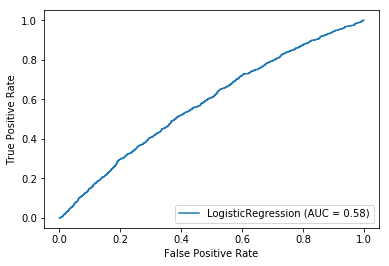

In [25]:
clf = LogisticRegression(class_weight = 'balanced').fit(Xtrain, ytrain.to_numpy().T[0])
baseline = roc_auc(clf, Xvalidate,yvalidate);

In [26]:
baseline

{'AUC': 0.5801585945705807, 'Mean_Accuracy': 0.609283276450512}

This is not a very good AUC. Though our model achieves a mean accuracy of .86 with an appropriate threshold, this ROC curve indicates that our data may not be linearly separable, which will lead to high instability in our model.

**Questions left to answer with validation** 

*Should funded amount be discretized?*

No.<sup><a href="#24" name="back24">24</a></sup>  Per my discussion above, loan amount is almost discrete, with the vast majority of points occurring on multiples of 1000. In the appendix, I investigate whether the model is improved by the creation of dummy variables from bins of loan amount. It turns out to increase AUC to .57, which is negligible.

*Should both grade and intrest rate be used, or just one?*

Both.<sup><a href="#25" name="back25">25</a></sup>  Per my discussion in the appendix at <sup><a href="#26" name="back26">26</a></sup>, grade and interest rate correlate very well, and it is possible that multicollinearity is a problem (though unlikely). I attempted removing interest rate, and AUC remained unchanged.

*Should I take the log of the lognormal distributions in our data set?*

Yes.<sup><a href="#27" name="back27">27</a></sup> Logistic regression is typically more robust on non-Gaussian distributions. However, in this case, it makes a clear difference to normalize the lognormal variables. The AUC improves to .64.



*Is month a useful categorical variable to add?*

No.<sup><a href="#28" name="back28">28</a></sup> Adding the month does not seem to improve AUC.

*Is reduced_by useful at all?*

No.<sup><a href="#29" name="back29">29</a></sup> As mentioned above, reduce_by is 0 in 99% of cases. Does it actually impact the success of our model? All things being equal, we should remove useless variables. It turns out that removing reduced_by does not impact our AUC. Thus, we should probably remove it in the final model.

*Will regularization help? (l2 or l1)*

Yes.<sup><a href="#30" name="back30">30</a></sup> It seems that regularization, and possibly changing the solver for the logistic regression, change the results considerably, bringing the AUC up to .64 independent of any other change.

**Integrate the new transformations**

In [27]:
Xtrain_final = Xtrain.drop("reduced_by",axis=1).copy()
Xvalidate_final = Xvalidate.drop("reduced_by",axis=1).copy()
Xtest_final = Xtest.drop("reduced_by",axis=1).copy()

Xtrain_final["annual_inc"] =  np.log10(Xtrain_final["annual_inc"] + 1)
Xtrain_final["dti"] =  np.log10(Xtrain_final["dti"] + 1)
Xtrain_final["revol_bal"] =  np.log10(Xtrain_final["revol_bal"] + 1)

Xvalidate_final["annual_inc"] =  np.log10(Xvalidate_final["annual_inc"] + 1)
Xvalidate_final["dti"] =  np.log10(Xvalidate_final["dti"] + 1)
Xvalidate_final["revol_bal"] =  np.log10(Xvalidate_final["revol_bal"] + 1)

Xtest_final["annual_inc"] =  np.log10(Xtest_final["annual_inc"] + 1)
Xtest_final["dti"] =  np.log10(Xtest_final["dti"] + 1)
Xtest_final["revol_bal"] =  np.log10(Xtest_final["revol_bal"] + 1)

### Step 3: Assess the Final Model

First, we assess the ROC curve on the validation set

{'AUC': 0.6593212515546364, 'Mean_Accuracy': 0.5903071672354949}

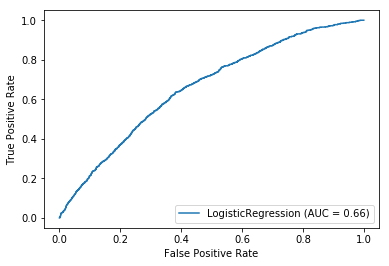

In [28]:
clf = LogisticRegression(class_weight = 'balanced', solver="liblinear", penalty="l1", max_iter=1000).fit(
                                                                        Xtrain_final, ytrain.to_numpy().T[0])
roc_auc(clf, Xvalidate_final,yvalidate)

And next, on the test set

{'AUC': 0.6489662729232141, 'Mean_Accuracy': 0.58182070112235}

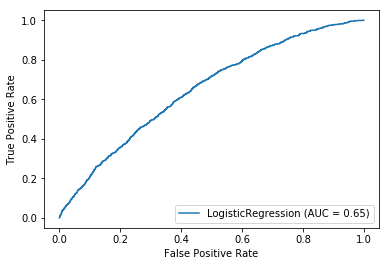

In [29]:
roc_auc(clf, Xtest_final,ytest)

*What would make the model effective?*

I would say the model is effective if we would expect it to achieve a modest decrease in the default rate, without throwing away too many valuable loans. I have defined an "improvement" function which calculates those terms for a variety of expected tpr. There is an annotated version in the appendix here<sup><a href="#31" name="back31">31</a></sup>.

In [30]:
def improvement(goal_tpr,probabilities,y):
    total_default = sum(1*y.to_numpy())[0]
    total_loans = len(1*y.to_numpy())
    fpr, tpr, thresholds = metrics.roc_curve(y, probabilities)   
    index = [i for i,j in enumerate(tpr >= goal_tpr) if j][0]
    total_flagged_loans = sum(1*(probabilities > thresholds[index]))
    flagged_loans_default = sum(1*y[probabilities > thresholds[index]].to_numpy())
    flagged_loans_fully_paid = sum(-1*(y[probabilities > thresholds[index]].to_numpy()-1))
    new_default_percent = round(
                (100*(total_default-flagged_loans_default)/(total_loans - total_flagged_loans)).item(),2)
    loans_rejected_percent = round(
                (100*(total_flagged_loans)/(total_loans)).item(),2)
    return {"default_percent":new_default_percent, "rejected_percent":loans_rejected_percent}

In [31]:
test_probs = clf.predict_proba(Xtest_final).T[1]
current_default_rate = round(100*(sum(1*ytest.to_numpy())/len(ytest))[0],2)

In [32]:
sumarry = {}
for tpr in range(0,11):
    im = improvement(tpr/10,test_probs,ytest)
    sumarry[tpr] = im
    sumarry[tpr]["percentage_point_improvement"] = current_default_rate - im["default_percent"]

All columns in this table are calculated with the test set data. This table has 3 columns:
1. **default_percent:** The expected default percentage after rejecting all loans exceeding the threshold
2. **rejected_percent:** The expected percentage of loans which will have to be rejected to achieve this default percent
3. **percentage_point_improvement:** The expected percentage point improvement in default percentage

In [33]:
df = pd.DataFrame(data=sumarry).T
df

,default_percent,rejected_percent,percentage_point_improvement
0,12.37,0.00,0.00
1,11.72,4.96,0.65
2,11.13,11.00,1.24
3,10.49,17.29,1.88
4,9.93,25.20,2.44
5,9.31,33.48,3.06
6,8.47,41.40,3.90
7,7.62,51.25,4.75
8,6.67,62.80,5.70
9,5.25,76.25,7.12


It would depend on the application, but to me this model does **not** seem to be very effective. 

In order to achieve a modest percentage point improvement in default rate of about 2%, we would have to throw out almost 20% of incoming loans if we were basing the choices on this model alone. 

# Appendix

This appendix contains (almost) all the code I ran during the process of exploring the data and answering the questions, in (almost) the order that I decided to run it.

## Part 1

### Initial Exploration

In [34]:
#Distinguish between categorical and numerical variables
cat = {c: type(raw_data[c][0]) == str for c in raw_data.columns}

In [35]:
def sample_level_stats(column):
    retval = {}
    retval["count"] =len(column)
    retval["missing_percent"] = column.isnull().sum() * 100 / retval["count"]
    
    
    if type(column[0]) == str:
        retval["cat"] = "cat"
        #retval["sum"] = 'N/A'
        retval["zero_percent"] = 'N/A'
        retval["mean"] = 'N/A'
        retval["std"] = 'N/A'
        vc = column.value_counts()
        retval["outlier_percent"] = sum(vc[vc/retval["count"] < .02]) * 100 /retval["count"]
        
        
    else:
        retval["cat"] = "quant"
        #retval["sum"] = sum(column)
        retval["mean"] = np.mean(column)
        retval["std"] = np.std(column)
        retval["zero_percent"] = column.apply(lambda x: 1 if x == 0 else 0).sum() * 100 / retval["count"]
        retval["outlier_percent"] = column.apply(
                                        lambda x: 1 if x > retval["mean"]+2*retval["std"] or
                                                        x < retval["mean"]-2*retval["std"] else 0
                                    ).sum() * 100 / retval["count"]
    return retval

In [36]:
#A summary table, to understand where cleaning might be necessary
summary = {c: sample_level_stats(raw_data[c]) for c in raw_data.columns}
pd.DataFrame(data=summary).round()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
count,887379,887379,887379,887379,887379,887379,887379,887379,887379,887379,887379
missing_percent,0,0,0,0,0,0.000450766,0,0,0,0,0
cat,quant,quant,cat,quant,cat,quant,cat,cat,quant,quant,quant
mean,14755.3,14741.9,N/A,13.2467,N/A,75027.6,N/A,N/A,18.157,16920.8,7558.83
std,8435.45,8429.89,N/A,4.38186,N/A,64698.3,N/A,N/A,17.1906,22426.8,7871.24
zero_percent,0,0,N/A,0,N/A,0.000225383,N/A,N/A,0.0508238,0.383376,2.00129
outlier_percent,5.18752,5.17141,0,3.47698,0.618563,1.8469,35.6284,3.67701,0.00473304,2.22351,5.45742


### Null Variables, Outliers, and Inconsistencies

In [37]:
#Check for any duplicate rows
np.any(raw_data.duplicated())

False

In [38]:
#Common Sense Checks:
#loan_amnt vs funded_amnt

In [39]:
np.any(raw_data["funded_amnt"] > raw_data["loan_amnt"])

False

In [40]:
#It seems that funded amount is the amount given out at the onset of the loan. 
#Though the schema for the data indicates that loan_amnt can be decreased, it seems it is never
#decreased bellow funded_amnt

<a href="#back4" name="4">(↑)</a> Some loans appear not to have been paid off, yet are marked as paid off

In [41]:
#Common Sense Checks:
# Does a loan_status of fully paid indicate a total payment of more than the loan amount?
raw_data[raw_data["loan_status"] == "Fully Paid"].apply(lambda x: x["funded_amnt"] > x["total_pymnt"], axis=1).sum()

452

In [42]:
#Apparently there are times when it does not. It seems that many of the loans have not been paid to the full amount
# yet have been marked fully paid. Visa-Versa, are there loans which are not fully paid, yet seem to have been paid
# off

In [43]:
raw_data[raw_data["loan_status"] != "Fully Paid"].apply(
    lambda x: (x["funded_amnt"]*(1+x["int_rate"]/100)) <= x["total_pymnt"], axis=1).sum()

9246

In [44]:
#Again, an issue. Though this could easily be due to fees unpaid, or something else.

In [45]:
#Are there any issue_d in the future? Luckily, no

In [46]:
np.any(pd.to_datetime(raw_data["issue_d"]) > pd.to_datetime("01/01/2016"))

False

In [47]:
#Missing At Random -- Check if values are different in cases where a value is missing, or not. 

<a href="#back3" name="3">(↑)</a> Missing income values all violate the credit policy

In [48]:
A = raw_data[raw_data["annual_inc"].isna()]
B = raw_data[~raw_data["annual_inc"].isna()].sample(len(A))

In [49]:
#All the missing income values seem to indicate a loan status of "does not meet credit policy"

In [50]:
A.append(B)

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
42449,5000.0,5000.0,36 months,7.43,A,NaN,Aug-2007,Does not meet the credit policy. Status:Fully ...,1.00,0.0,5593.46
42450,7000.0,7000.0,36 months,7.75,A,NaN,Aug-2007,Does not meet the credit policy. Status:Fully ...,1.00,0.0,7867.53
42480,6700.0,6700.0,36 months,7.75,A,NaN,Jul-2007,Does not meet the credit policy. Status:Fully ...,1.00,0.0,7530.42
42533,6500.0,6500.0,36 months,8.38,A,NaN,Jun-2007,Does not meet the credit policy. Status:Fully ...,4.00,0.0,7373.83
36951,8200.0,8200.0,36 months,12.21,B,34000.0,Apr-2009,Fully Paid,8.72,6383.0,9816.52
256298,9600.0,9600.0,36 months,13.66,C,40000.0,Nov-2014,Current,4.80,4962.0,4230.32
824519,10000.0,10000.0,36 months,10.99,B,58000.0,Mar-2015,Current,9.91,6340.0,3267.29
337053,13200.0,13200.0,60 months,11.67,B,50000.0,Jul-2014,Current,9.17,10892.0,4954.48


In [51]:
A = raw_data[raw_data["annual_inc"]==0]
B = raw_data[~(raw_data["annual_inc"]==0)].sample(len(A))

In [52]:
#Now I'll check the zero values.

In [53]:
A.append(B)

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
484446,20000.0,20000.0,36 months,16.99,D,0.0,Dec-2015,Current,9999.00,7161.0,694.08
531886,3700.0,3700.0,36 months,12.59,C,0.0,Nov-2015,Current,9999.00,10649.0,242.70
199785,27000.0,27000.0,60 months,20.49,E,68875.0,Sep-2012,Current,19.62,33090.0,28161.94
797801,15000.0,15000.0,36 months,16.99,D,45000.0,Apr-2015,Current,27.79,4256.0,4798.32


<a href="#back1" name="1">(↑)</a> DTI division by zero issue

In [54]:
#These seem to be ok. It makes sense that a few loans would be given out with zero income, perhaps to trusted
# customers of some kind. However, this highlights an issue with "dti" being blown up out of proportion, due to
#division by zero

In [55]:
#Let's now check the zeros for dti

In [56]:
A = raw_data[raw_data["dti"]==0].sample(3)
B = raw_data[~(raw_data["dti"]==0)].sample(len(A))

In [57]:
A.append(B)

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
26203,6000.0,6000.0,36 months,7.88,A,70000.0,Sep-2010,Fully Paid,0.00,0.0,6755.960000
240702,20000.0,20000.0,60 months,14.99,C,42000.0,Dec-2014,Fully Paid,0.00,0.0,20074.960000
22291,10000.0,10000.0,36 months,5.79,A,24000.0,Dec-2010,Fully Paid,0.00,0.0,10914.290000
814408,15000.0,15000.0,60 months,21.67,E,45200.0,Mar-2015,Current,29.90,10137.0,4096.740000
174982,9600.0,9600.0,36 months,15.80,C,52000.0,Jan-2013,Fully Paid,22.06,8379.0,11621.816625
746998,30000.0,30000.0,60 months,10.99,B,98000.0,Jun-2015,Current,18.47,99379.0,4439.460000


In [58]:
#Seems ok, and from the defenition:
#A ratio calculated using the co-borrowers' 
#total monthly payments on the total debt obligations,
#excluding mortgages and the requested LC loan, divided by the co-borrowers'
#combined self-reported monthly income
#seems likely to just be customers with no other debt obligations. 

In [59]:
#Now, how many loans exactly "Do not meet the credit policy"

In [60]:
(raw_data["loan_status"] == 'Does not meet the credit policy. Status:Charged Off').sum()

761

In [61]:
(raw_data["loan_status"] == 'Does not meet the credit policy. Status:Fully Paid').sum()

1988

In [62]:
#Seems safe enough to remove these, they represent a very small number of cases compared to the overall dataset.

### Correlatations

In [63]:
#Let's take a look at the correlations, and see if any variables are very correlated right off the bat.
#2 Variables that are strongly correlated (and essentially carry the same information) can mess with
# Logistic Regression, so it's important to take a look. 

<a href="#back2" name="2">(↑)</a> Correlation between loan_amnt and funded_amnt

In [64]:
raw_data.corr(method="pearson") #A good start, but can be biased by outliers

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
loan_amnt,1.000000,0.999263,0.145023,0.332698,0.020675,0.333580,0.474626
funded_amnt,0.999263,1.000000,0.145160,0.332466,0.021075,0.333435,0.473286
int_rate,0.145023,0.145160,1.000000,-0.072786,0.079903,-0.035708,0.170506
annual_inc,0.332698,0.332466,-0.072786,1.000000,-0.087410,0.295784,0.160879
dti,0.020675,0.021075,0.079903,-0.087410,1.000000,0.067277,-0.041529
revol_bal,0.333580,0.333435,-0.035708,0.295784,0.067277,1.000000,0.138328
total_pymnt,0.474626,0.473286,0.170506,0.160879,-0.041529,0.138328,1.000000


In [65]:
#Conclusions here: loan_amnt and funded_amnt correlate too well for logistic regression.
#The loan_amnt variable is described as:

#The listed amount of the loan applied for by the borrower. 
#If at some point in time, the credit department reduces the 
#loan amount, then it will be reflected in this value.

#The funded_amnt is described as the committed to the loand at that point in time.
#It seems to make sense to replace loan_amnt with a "reduced by" variable.

In [66]:
#It will be useful to have some ordinal encodings for the spearman analysis, and in general
# (I made up some encodings for loan_status that seemed to make sense)
ordinal_encodings = {
    "grade" : {chr(65+i):i for i in range(7)},
    "term" : {" 36 months":0," 60 months": 1},
    "loan_status":{'Charged Off':0,
                   'Current': 2,
                   'Default': 0,
                   'Does not meet the credit policy. Status:Charged Off': 0,
                   'Does not meet the credit policy. Status:Fully Paid': 0,
                   'Fully Paid': 2,
                   'In Grace Period': 1,
                   'Issued': 2,
                   'Late (16-30 days)': 1,
                   'Late (31-120 days)': 1
    }
    
}
spear_data = raw_data.copy()
spear_data["grade"] = raw_data["grade"].apply(lambda x: ordinal_encodings["grade"][x])
spear_data["term"] = raw_data["term"].apply(lambda x: ordinal_encodings["term"][x])
spear_data["loan_status"] = raw_data["loan_status"].apply(lambda x: ordinal_encodings["loan_status"][x])

In [67]:
spear_data.corr(method="spearman") #Works well with ordinal values, but poorly for clusters

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,loan_status,dti,revol_bal,total_pymnt
loan_amnt,1.000000,0.999368,0.440779,0.116829,0.119229,0.504496,0.003909,0.056072,0.499924,0.419696
funded_amnt,0.999368,1.000000,0.440037,0.117159,0.119318,0.504197,0.004729,0.056831,0.499784,0.418562
term,0.440779,0.440037,1.000000,0.415687,0.430676,0.134927,-0.035024,0.105601,0.176064,0.059784
int_rate,0.116829,0.117159,0.415687,1.000000,0.952441,-0.122830,-0.170250,0.164973,-0.031969,0.151513
grade,0.119229,0.119318,0.430676,0.952441,1.000000,-0.114977,-0.147731,0.172572,-0.034983,0.040187
annual_inc,0.504496,0.504197,0.134927,-0.122830,-0.114977,1.000000,0.058265,-0.210363,0.411213,0.216266
loan_status,0.003909,0.004729,-0.035024,-0.170250,-0.147731,0.058265,1.000000,-0.019967,0.023268,0.001334
dti,0.056072,0.056831,0.105601,0.164973,0.172572,-0.210363,-0.019967,1.000000,0.247720,-0.083429
revol_bal,0.499924,0.499784,0.176064,-0.031969,-0.034983,0.411213,0.023268,0.247720,1.000000,0.211530
total_pymnt,0.419696,0.418562,0.059784,0.151513,0.040187,0.216266,0.001334,-0.083429,0.211530,1.000000


<a href="#back26" name="26">(↑)</a> Correlation between grade and int_rate

In [68]:
#Conclusions here: grade and int_rate correlate very well, perhaps grade should be removed from the final regression.

In [69]:
#Now let's have a look at the correlations after variables have been replaced, and data cleaned

In [70]:
cat["reduced_by"] = False # Update the cat dictionary
data.corr(method="pearson")

,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt,reduced_by,defaulted
funded_amnt,1.000000,0.181270,0.283016,0.369983,0.324279,0.934982,0.000393,-0.000791
int_rate,0.181270,1.000000,0.005259,0.138565,0.064306,0.195756,-0.050624,0.149523
annual_inc,0.283016,0.005259,1.000000,0.426825,0.340182,0.275553,0.029468,-0.050938
dti,0.369983,0.138565,0.426825,1.000000,0.522167,0.364862,0.014182,-0.022324
revol_bal,0.324279,0.064306,0.340182,0.522167,1.000000,0.313566,0.045728,-0.014869
total_pymnt,0.934982,0.195756,0.275553,0.364862,0.313566,1.000000,-0.001121,-0.244972
reduced_by,0.000393,-0.050624,0.029468,0.014182,0.045728,-0.001121,1.000000,-0.003237
defaulted,-0.000791,0.149523,-0.050938,-0.022324,-0.014869,-0.244972,-0.003237,1.000000


In [71]:
spear_data = data.copy()
spear_data["grade"] = data["grade"].apply(lambda x: ordinal_encodings["grade"][x])
spear_data["loan_status"] = data["loan_status"].apply(lambda x: ordinal_encodings["loan_status"][x])
spear_data.corr(method="spearman") 

,funded_amnt,int_rate,grade,annual_inc,loan_status,dti,revol_bal,total_pymnt,reduced_by,defaulted
funded_amnt,1.000000,0.153043,0.123831,0.406388,0.000655,0.354798,0.413662,0.917523,-0.005651,0.000039
int_rate,0.153043,1.000000,0.932140,-0.006104,-0.148540,0.136938,0.134100,0.150195,-0.073550,0.149093
grade,0.123831,0.932140,1.000000,-0.006904,-0.142814,0.100537,0.102959,0.120790,-0.041325,0.143092
annual_inc,0.406388,-0.006104,-0.006904,1.000000,0.087416,0.578076,0.379855,0.395207,0.033681,-0.086604
loan_status,0.000655,-0.148540,-0.142814,0.087416,1.000000,0.018325,0.010177,0.296435,0.005225,-0.997855
dti,0.354798,0.136938,0.100537,0.578076,0.018325,1.000000,0.548834,0.340626,0.000982,-0.017096
revol_bal,0.413662,0.134100,0.102959,0.379855,0.010177,0.548834,1.000000,0.393075,0.028100,-0.009370
total_pymnt,0.917523,0.150195,0.120790,0.395207,0.296435,0.340626,0.393075,1.000000,-0.008046,-0.294637
reduced_by,-0.005651,-0.073550,-0.041325,0.033681,0.005225,0.000982,0.028100,-0.008046,1.000000,-0.005403
defaulted,0.000039,0.149093,0.143092,-0.086604,-0.997855,-0.017096,-0.009370,-0.294637,-0.005403,1.000000


### Feature Distributions

<a href="#back6" name="6">(↑)</a> **funded_amnt**

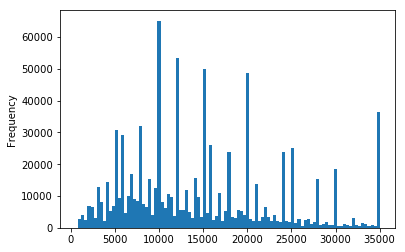

In [72]:
raw_data['funded_amnt'].plot(kind="hist", bins= 100);

In [73]:
np.mean(raw_data['funded_amnt'])

14741.877625005776

<a href="#back7" name="7">(↑)</a>   **loan_amnt**

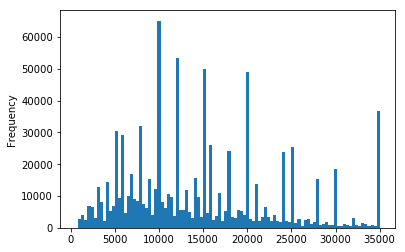

In [74]:
raw_data['loan_amnt'].plot(kind="hist", bins= 100);

In [75]:
np.mean(raw_data['loan_amnt'])

14755.26460508982

<a href="#back8" name="8">(↑)</a>   **term**

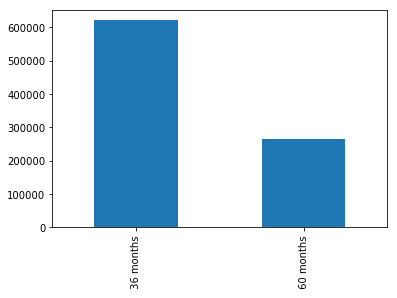

In [76]:
raw_data["term"].value_counts().plot(kind="bar");

<a href="#back9" name="9">(↑)</a>   **int_rate**

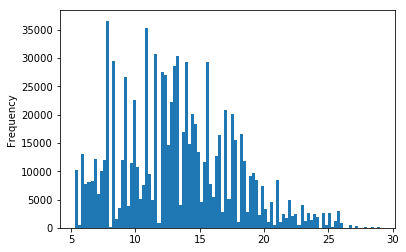

In [77]:
raw_data['int_rate'].plot(kind="hist", bins=100);

In [78]:
np.mean(raw_data['int_rate'])

13.246739679437987

<a href="#back10" name="10">(↑)</a>   **grade**

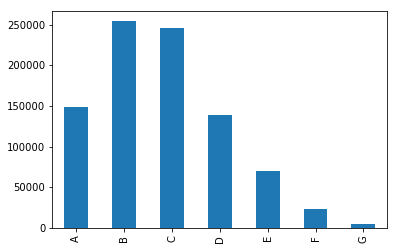

In [79]:
raw_data["grade"].value_counts().sort_index().plot(kind="bar");

<a name="11"><a href="#back5" name="5">(↑)</a>   **annual_inc**

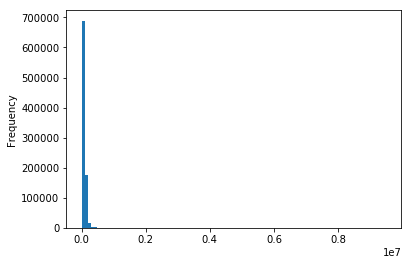

In [80]:
raw_data['annual_inc'].plot(kind="hist", bins = 100);

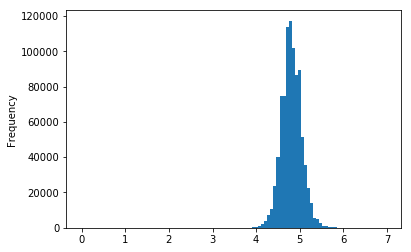

In [81]:
np.log10(raw_data['annual_inc']+1).plot(kind="hist", bins = 100);

In [82]:
#Seems to be lognormal, which is to be expected from income.

<a href="#back12" name="12">(↑)</a>   **issue_d**

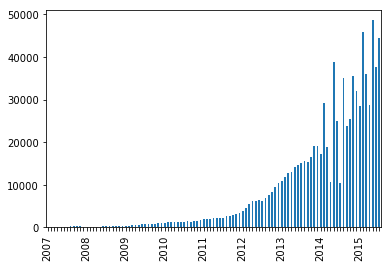

In [83]:
dates = pd.to_datetime(raw_data["issue_d"]) #Standard Conversion to datetime type
ax = dates.value_counts().sort_index().plot(kind="bar");
ax.set_xticklabels([str(int(i/12)) if i % 12 == 0 else "" for i in range(2007*12,2016*12+1)]);

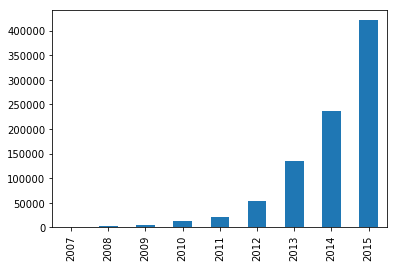

In [84]:
#Let's take a look by year
ax = dates.dt.year.value_counts().sort_index().plot(kind="bar");

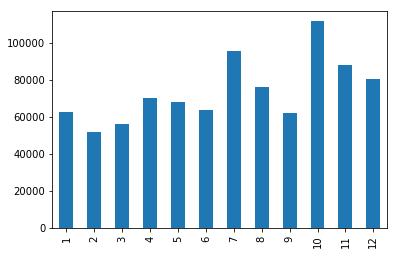

In [85]:
#And now by month
ax = dates.dt.month.value_counts().sort_index().plot(kind="bar");

In [86]:
#No one month looks especially popular

<a href="#back13" name="13">(↑)</a>   **loan_status**

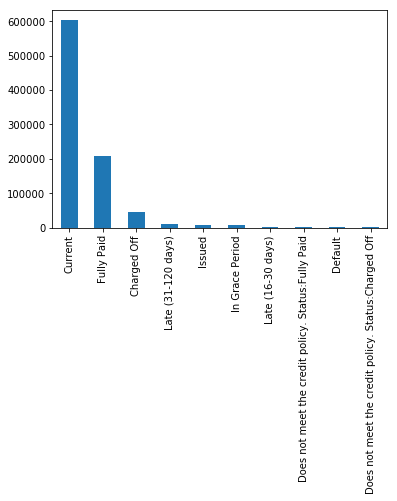

In [87]:
raw_data["loan_status"].value_counts().plot(kind="bar");

<a href="#back14" name="14">(↑)</a>   **dti**

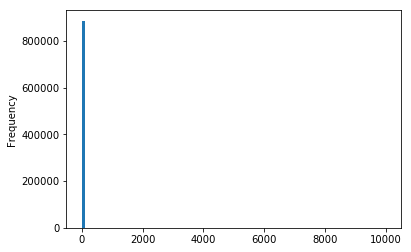

In [88]:
raw_data['dti'].plot(kind="hist", bins = 100);

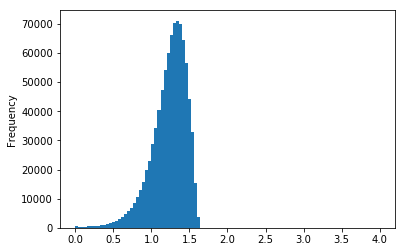

In [89]:
np.log10(raw_data['dti']+1).plot(kind="hist", bins = 100);

In [90]:
#After adjusting dti by annual_inc, we deal with the (high value) outliers in the lognormal distrobution. 

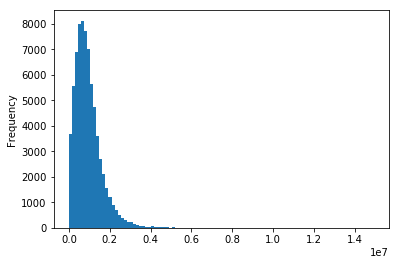

In [91]:
data['dti'].plot(kind="hist", bins = 100);

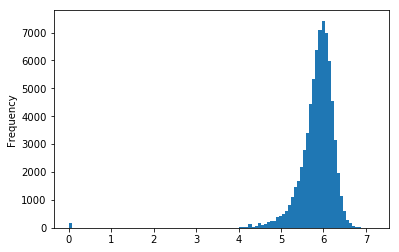

In [92]:
np.log10(data['dti']+1).plot(kind="hist", bins = 100);

In [93]:
# A few zeros make sense, for those with no other debts than the loan currently being taken out

<a href="#back15" name="15">(↑)</a>   **revol_bal** 

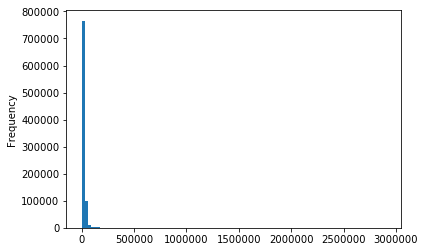

In [94]:
raw_data['revol_bal'].plot(kind="hist", bins = 100);

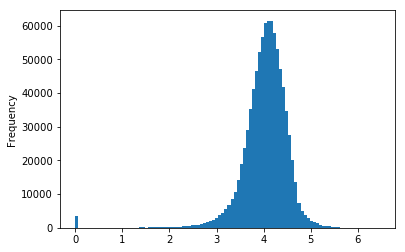

In [95]:
np.log10(raw_data['revol_bal']+1).plot(kind="hist", bins = 100);

<a href="#back16" name="16">(↑)</a>   **total_pymnt**

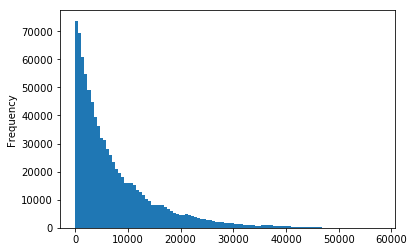

In [96]:
raw_data['total_pymnt'].plot(kind="hist", bins = 100);

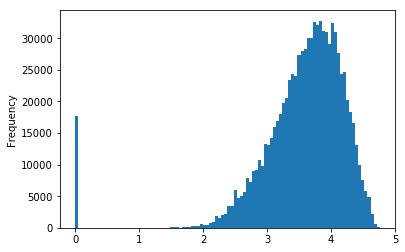

In [97]:
np.log10(raw_data['total_pymnt']+1).plot(kind="hist", bins = 100);

In [98]:
#It seems quite a few loans have not even begun to be repaid. 

In [99]:
#I'd like to consider the "Percent Repaid" of all loans.

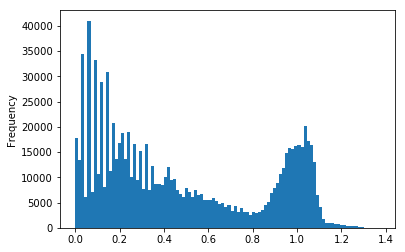

In [100]:
(raw_data['total_pymnt']/(raw_data['loan_amnt']*(1+raw_data["int_rate"]/100))).plot(kind="hist", bins = 100);

In [101]:
#It seems that some folks probably pay fees, and that there are some very common milestones where people 
#give up on their loans. 

<a href="#back17" name="17">(↑)</a>   **reduced_by**

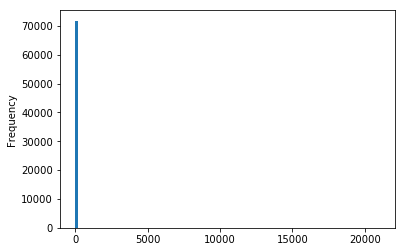

In [102]:
data['reduced_by'].plot(kind="hist", bins = 100);

In [103]:
sum(data['reduced_by'] == 0)/len(data)

0.9894303117162307

In [104]:
#It seems the vast majority of loans are given for the amount requested

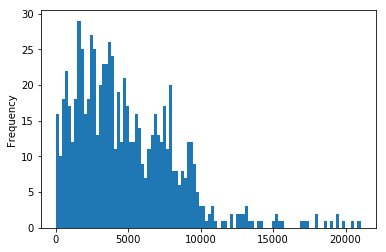

In [105]:
data[data['reduced_by'] > 0]['reduced_by'].plot(kind="hist", bins = 100);

In [106]:
#Of those loans which have their value reduced, the distribution is fairly normal

### Further Data Cleaning

<a href="#back18" name="18">(↑)</a>  Removal of loans with less than 36 months of data excludes almost 90% of loans

In [107]:
sum((dates >=  pd.to_datetime("01/01/2013"))*1)/len(dates)

0.8919266739465325

<a href="#back19" name="19">(↑)</a>  There are loans marked current, even in the cleaned data. Luckily, only 33

In [108]:
data["loan_status"].value_counts()

Fully Paid            63357
Charged Off            9071
Late (31-120 days)       81
Current                  33
Default                  12
In Grace Period           6
Late (16-30 days)         6
Name: loan_status, dtype: int64

### Cohort with highest default rates

In [109]:
sumarry = {}
for g in set(data["grade"]):
    sumarry[g] = {}
    for yr in set(data["issue_d"].dt.year):
        d = data[np.logical_and(data["grade"] == g, data["issue_d"].dt.year == yr)]["defaulted"]
        if sum(d*1) > 0:
            sumarry[g][yr] = round(100*sum(d*1)/len(d))
        else:
            sumarry[g][yr] = "N/A"

<a href="#back20" name="20">(↑)</a> G, 2008 has the highest rate of default (50%)

In [110]:
df = pd.DataFrame(sumarry)
df = df.reindex(sorted(df.columns), axis=1)
df

,A,B,C,D,E,F,G
2007,2,13,19,41,36,29,N/A
2008,6,15,18,24,16,48,50
2009,7,11,15,17,22,17,35
2010,4,9,13,16,19,31,37
2011,6,11,16,18,21,24,40
2012,7,13,18,21,22,18,17


In [111]:
sumarry = {}
for g in set(data["grade"]):
    sumarry[g] = {}
    for yr in set(data["issue_d"].dt.year):
        d = data[np.logical_and(data["grade"] == g, data["issue_d"].dt.year == yr)]["defaulted"]
        if sum(d*1) > 0:
            sumarry[g][yr] = len(d)
        else:
            sumarry[g][yr] = "N/A"

In [112]:
#There are, however, only 4 loans in that cohort

In [113]:
df = pd.DataFrame(sumarry)
df = df.reindex(sorted(df.columns), axis=1)
df

,A,B,C,D,E,F,G
2007,57,61,75,37,14,7,N/A
2008,295,507,438,222,75,21,4
2009,1178,1365,1193,657,236,64,23
2010,2541,2676,1840,1054,271,65,19
2011,5579,4722,2203,1261,272,54,10
2012,10753,16805,9902,5088,795,103,24


In [114]:
#My instinct is to take a look at them, but there are no obvious anomalies. 

In [115]:
data[np.logical_and(data["grade"] == "G",data["issue_d"].dt.year == 2008)]

,funded_amnt,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt,reduced_by,defaulted
27563,24000.0,18.72,G,60000.0,2008-11-01,Charged Off,1188000.0,23555.0,2627.79,0.0,True
27588,12500.0,19.04,G,123000.0,2008-11-01,Charged Off,718320.0,13363.0,14025.37,0.0,True
28418,25000.0,17.34,G,96000.0,2008-03-01,Fully Paid,1804800.0,14706.0,32593.79,0.0,False
28749,13875.0,18.36,G,84000.0,2008-01-01,Fully Paid,1935360.0,24280.0,18061.74,10750.0,False


### Annualized Rate of Return

In [116]:
sumarry = {}
for g in set(data["grade"]):
    sumarry[g] = {}
    for yr in set(data["issue_d"].dt.year):
        tp = data[np.logical_and(data["grade"] == g, data["issue_d"].dt.year == yr)]["total_pymnt"]
        fa = data[np.logical_and(data["grade"] == g, data["issue_d"].dt.year == yr)]["funded_amnt"]
        if len(tp) > 0:
            sumarry[g][yr] = str(round(np.std(annualized_ror(tp,fa)),2))
        else:
            sumarry[g][yr] = "N/A"
        

<a href="#back21" name="21">(↑)</a> The STD of the annualized rate of return varies between cohorts

In [117]:
df = pd.DataFrame(sumarry)
df = df.reindex(sorted(df.columns), axis=1)
df.style.set_caption("STD of the Annualized Rate of Return by Year of Origination, Grade")

,A,B,C,D,E,F,G
2007,0.03,0.09,0.1,0.13,0.12,0.08,N/A
2008,0.05,0.11,0.12,0.16,0.12,0.2,0.26
2009,0.07,0.12,0.14,0.13,0.17,0.1,0.15
2010,0.05,0.09,0.11,0.13,0.14,0.18,0.18
2011,0.07,0.09,0.12,0.13,0.14,0.14,0.17
2012,0.08,0.1,0.12,0.13,0.14,0.15,0.15


## Part 2

### Step 1

<a href="#back22" name="22">(↑)</a> Should I separate or normalize by year? Because Default rates drop by half over the period from 2007 to 2010, it seems to me that year plays a large role in default rate. 

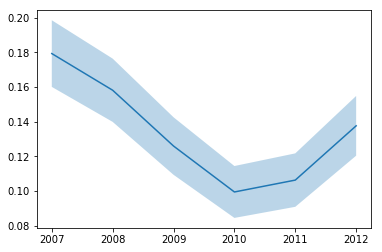

In [118]:
#I've added the STD just to get a sense for how it changes
avg_by_year = data.groupby(data["issue_d"].dt.year)["defaulted"].mean()
std_by_year = data.groupby(data["issue_d"].dt.year)["defaulted"].std()*.05
plt.plot(avg_by_year);
plt.fill_between(range(2007,2013), avg_by_year-std_by_year, avg_by_year+std_by_year, alpha=.3);

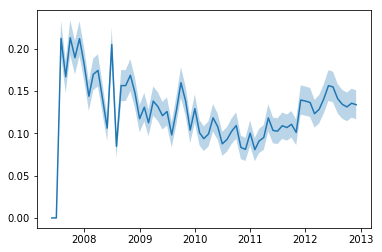

In [119]:
avg_by_month = data.groupby("issue_d")["defaulted"].mean()
std_by_month = data.groupby("issue_d")["defaulted"].std()*.05
plt.plot(avg_by_month);
plt.fill_between(avg_by_month.keys(), avg_by_month-std_by_month, avg_by_month+std_by_month, alpha=.3);

In [120]:
#It seems there's probably too much variation to use the last month's default rate, for example, in the regression
#usefully. And current month might allow too much "peeking"

<a href="#back23" name="23">(↑)</a> Later years have way more loans than earlier years

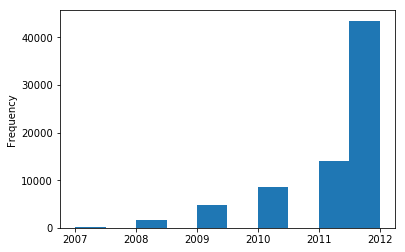

In [121]:
data["issue_d"].dt.year.plot(kind="hist")

### Step 2

<a href="#back24" name="24">(↑)</a> Should loan amount be discretized?

In [122]:
Xtrain_experimental = pd.concat((Xtrain, pd.get_dummies(
    pd.cut(Xtrain["funded_amnt"],range(0,36000,1000)),prefix="funded")),axis=1).drop("funded_amnt",axis=1)
Xvalidate_experimental = pd.concat((Xvalidate, pd.get_dummies(
    pd.cut(Xvalidate["funded_amnt"],range(0,36000,1000)),prefix="funded")),axis=1).drop("funded_amnt",axis=1)

{'AUC': 0.551772294152973, 'Mean_Accuracy': 0.6763139931740614}

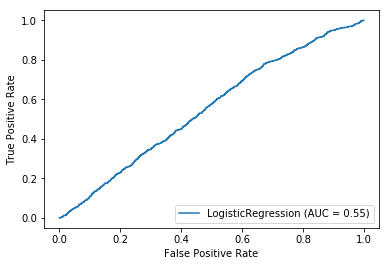

In [123]:
clf = LogisticRegression(class_weight = 'balanced').fit(Xtrain_experimental, ytrain.to_numpy().T[0])
roc_auc(clf, Xvalidate_experimental,yvalidate)

<a href="#back25" name="25">(↑)</a> Should I remove int_rate because of it's correlation with grade?

In [124]:
Xtrain_experimental = Xtrain.drop("int_rate",axis=1)
Xvalidate_experimental = Xvalidate.drop("int_rate",axis=1)

{'AUC': 0.5801570351693492, 'Mean_Accuracy': 0.6091467576791809}

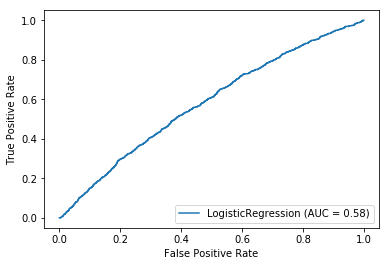

In [125]:
clf = LogisticRegression(class_weight = 'balanced').fit(Xtrain_experimental, ytrain.to_numpy().T[0])
roc_auc(clf, Xvalidate_experimental,yvalidate)

<a href="#back27" name="27">(↑)</a> Should I take the log of the lognormal distributions?

In [126]:
Xtrain_experimental["annual_inc"] =  np.log10(Xtrain["annual_inc"] + 1)
Xtrain_experimental["dti"] =  np.log10(Xtrain["dti"] + 1)
Xtrain_experimental["revol_bal"] =  np.log10(Xtrain["revol_bal"] + 1)

Xvalidate_experimental["annual_inc"] =  np.log10(Xvalidate["annual_inc"] + 1)
Xvalidate_experimental["dti"] =  np.log10(Xvalidate["dti"] + 1)
Xvalidate_experimental["revol_bal"] =  np.log10(Xvalidate["revol_bal"] + 1)

{'AUC': 0.5583079179810397, 'Mean_Accuracy': 0.8774061433447099}

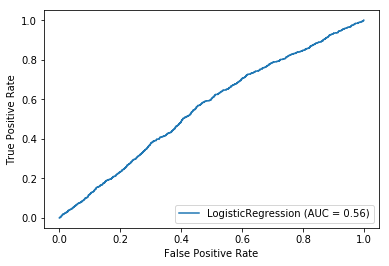

In [127]:
clf = LogisticRegression().fit(Xtrain_experimental, ytrain.to_numpy().T[0])
roc_auc(clf, Xvalidate_experimental,yvalidate)

<a href="#back28" name="28">(↑)</a> Should I add month?

In [128]:
Xtrain_experimental = Xtrain.merge(
    pd.get_dummies(data["issue_d"].dt.month),left_index=True, right_index=True)
Xvalidate_experimental = Xvalidate.merge(
    pd.get_dummies(data["issue_d"].dt.month),left_index=True, right_index=True)

{'AUC': 0.5801585945705807, 'Mean_Accuracy': 0.609283276450512}

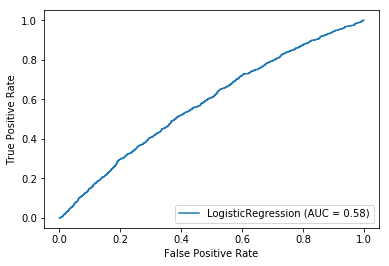

In [129]:
clf = LogisticRegression(class_weight = 'balanced').fit(Xtrain_experimental, ytrain.to_numpy().T[0])
roc_auc(clf, Xvalidate_experimental,yvalidate)

<a href="#back29" name="29">(↑)</a> Should I keep reduced_by?

In [130]:
Xtrain_experimental = Xtrain.drop("reduced_by",axis=1)
Xvalidate_experimental = Xvalidate.drop("reduced_by",axis=1)

{'AUC': 0.5801584213037773, 'Mean_Accuracy': 0.6090102389078498}

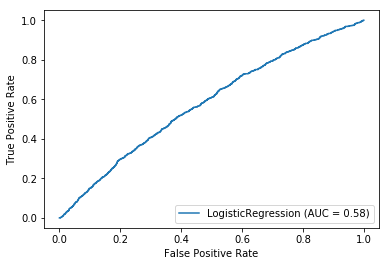

In [131]:
clf = LogisticRegression(class_weight = 'balanced').fit(Xtrain_experimental, ytrain.to_numpy().T[0])
roc_auc(clf, Xvalidate_experimental,yvalidate)

<a href="#back30" name="30">(↑)</a> Will regularization help?

In [132]:
baseline

{'AUC': 0.5801585945705807, 'Mean_Accuracy': 0.609283276450512}

{'AUC': 0.6574095989116072, 'Mean_Accuracy': 0.5724232081911262}

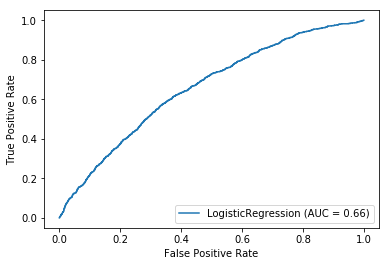

In [133]:
clf = LogisticRegression(
    class_weight = 'balanced', penalty='l1', solver="liblinear").fit(Xtrain, ytrain.to_numpy().T[0])
roc_auc(clf, Xvalidate,yvalidate)

{'AUC': 0.6497784090850023, 'Mean_Accuracy': 0.5138566552901024}

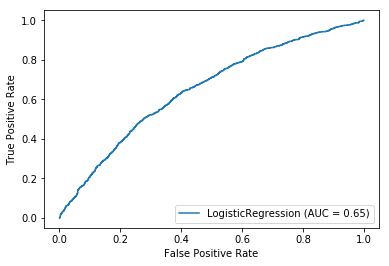

In [134]:
clf = LogisticRegression(class_weight = 'balanced', penalty='l2', solver="liblinear").fit(Xtrain, ytrain.to_numpy().T[0])
roc_auc(clf, Xvalidate,yvalidate)

In [135]:
# I hadn't fully considered that changing the solver also changes the solution. Given more time, I would go
#back to the basics to find out why we get different results under the hood.
#clf = LogisticRegression(class_weight = 'balanced', solver="newton-cg").fit(Xtrain, ytrain.to_numpy().T[0])
#roc_auc(clf, Xvalidate,yvalidate)

### Step 3

<a href="#back31" name="31">(↑)</a> A function for finding the new default percentage and the number of loans thrown away

In [136]:
def improvement(goal_tpr,probabilities,y):
    #In the test set, there are 936 loans which default
    total_default = sum(1*y.to_numpy())[0]
    #out of 7465 loans
    total_loans = len(1*y.to_numpy())
    

    fpr, tpr, thresholds = metrics.roc_curve(y, probabilities)
    
    index = [i for i,j in enumerate(tpr >= goal_tpr) if j][0]
    
    #We will have to remove 2466 loans (with tpr=.5 in the test set)
    total_flagged_loans = sum(1*(probabilities > thresholds[index]))
    
    #Of those, 467 will be defaults
    flagged_loans_default = sum(1*y[probabilities > thresholds[index]].to_numpy())
    
    #And 1999 will be good loans
    flagged_loans_fully_paid = sum(-1*(y[probabilities > thresholds[index]].to_numpy()-1))
    
    #Our new default percentage will be
    new_default_percent = round(
                (100*(total_default-flagged_loans_default)/(total_loans - total_flagged_loans)).item(),2)
    
    #But, we rejected this many loans
    loans_rejected_percent = round(
                (100*(total_flagged_loans)/(total_loans)).item(),2)
    
    return {"default_percent":new_default_percent, "rejected_percent":loans_rejected_percent}